# Fitting a Group of Power Spectra

In this example, we will fit a group of power spectra.

## Load Python libraries

First, we will load the Python modules we need for this tutorial.

In [1]:
# Import some useful standard library modules
import os
from pathlib import Path

# Import some general scientific python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the parameterization model group object
from fooof import FOOOF,FOOOFGroup

# Import useful parameterization related utilities and plot functions
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum
from fooof.data import FOOOFSettings
from fooof.plts import plot_spectrum
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits

# Import functions to examine frequency-by-frequency error of model fits
from fooof.analysis.error import compute_pointwise_error_fg

/tmp/ipykernel_54025/3799920273.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF,FOOOFGroup


### Check specparam version

In [2]:
# Check which version we are using
import fooof
print(fooof.__version__)

1.1.0


## Set data path

Next, we can set the path to where the data is available.

In [3]:
# Check current directory
os.getcwd()

'/home/hyruuk/GitHub/cocolab/cc_saflow/notebooks'

In [4]:
# Set the data path to load from
data_path = Path('../Data/')

In [5]:
# Set the path to output folder
output_path = Path('../Output/')

## Load group PSDs

Load CSV files, including:
- `freqs.csv`, which contains a vector of frequencies
- `eopPSDs.csv`, which contains the power values for a group of power spectrum, one for each subject

In [6]:
# Load csv files containing frequency and power values
freqs = np.ravel(pd.read_csv(data_path / "freqs.csv"))                                                             
spectra = np.array(pd.read_csv(data_path / "eop.csv"))[:,1:101]  

FileNotFoundError: [Errno 2] No such file or directory: '../Data/freqs.csv'

In [ ]:
# Check shapes of loaded data
print(freqs.shape)
print(spectra.shape)

(99,)
(60, 99)


In [7]:
# Get the number of subjects
n_subjs = spectra.shape[0]
print('There are {:d} subjects.'.format(n_subjs))

NameError: name 'spectra' is not defined

## Load SAflow data

In [8]:
import saflow
import mne_bids
from saflow.features.utils import create_fnames, segment_sourcelevel
import mne

subject = '12'
run = '02'
n_trials = 8
filepaths = create_fnames(subject, run)
raw = mne_bids.read_raw_bids(filepaths['preproc'])
picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False)
data = raw.get_data()[picks,:]
sfreq = raw.info['sfreq']

segmented_array, events_idx, events_dicts = segment_sourcelevel(data, filepaths, sfreq=sfreq, n_events_window=n_trials)
welch_array = mne.time_frequency.psd_array_welch(segmented_array, sfreq=sfreq, n_jobs=-1, n_fft=1022, n_overlap=512)#n_fft=segmented_array.shape[-1])



Opening raw data file /media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/preprocessed/sub-12/meg/sub-12_task-gradCPT_run-02_proc-clean_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.
Current compensation grade : 3
Reading events from /media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/preprocessed/sub-12/meg/sub-12_task-gradCPT_run-02_proc-clean_events.tsv.
Reading channel info from /media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/preprocessed/sub-12/meg/sub-12_task-gradCPT_run-02_proc-clean_channels.tsv.
Cannot verify that the cHPI frequencies from the MEG JSON sidecar file correspond to the raw data.
Not fully anonymizing info - keeping his_id, sex, and hand info
Effective window size : 0.852 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   56.9s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  1.3min remaining:   46.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.4min finished


In [9]:
freqs = welch_array[1]
spectra = welch_array[0][:,0,:]

## Fit power spectra

Now we can parameterize our group of power spectra!

In [10]:
# Define `peak_width_limit` setting
peak_width = [1, 8]

# Define `max_n_peaks` setting
n_peaks = 4

# Define `min_peak_height` setting
peak_height = 0.10

# Define frequency range
PSD_range = [2, 120]

In [11]:
# Initialize a model object for spectral parameterization, with some settings 
fg = FOOOFGroup(peak_width_limits=peak_width, max_n_peaks=n_peaks, min_peak_height=peak_height, verbose=False, aperiodic_mode='knee')

In [12]:
# Fit group PSDs over the 3-40 Hz range      
fg.copy().fit(freqs, spectra, PSD_range)

/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar multiply
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs

/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:3

In [16]:
fg.get_fooof(0)

TypeError: 'NoneType' object is not subscriptable

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 555                             
                                                                                                  
                       The model was run on the frequency range 2 - 120 Hz                        
                                 Frequency Resolution is 1.17 Hz                                  
                                                                                                  
                               Power spectra were fit with a knee.                                
                                                                                                  
          

offset       -26.118451
knee          26.069992
exponent       1.491642
delta_cf            NaN
delta_pw            NaN
delta_bw            NaN
theta_cf       5.548402
theta_pw       0.386303
theta_bw       2.967777
alpha_cf            NaN
alpha_pw            NaN
alpha_bw            NaN
lobeta_cf     18.644422
lobeta_pw      0.286942
lobeta_bw      3.333307
hibeta_cf     26.061497
hibeta_pw      0.548395
hibeta_bw      8.000000
gamma1_cf           NaN
gamma1_pw           NaN
gamma1_bw           NaN
gamma2_cf           NaN
gamma2_pw           NaN
gamma2_bw           NaN
gamma3_cf    111.403920
gamma3_pw      0.353523
gamma3_bw      8.000000
error          0.094143
r_squared      0.946867
dtype: float64

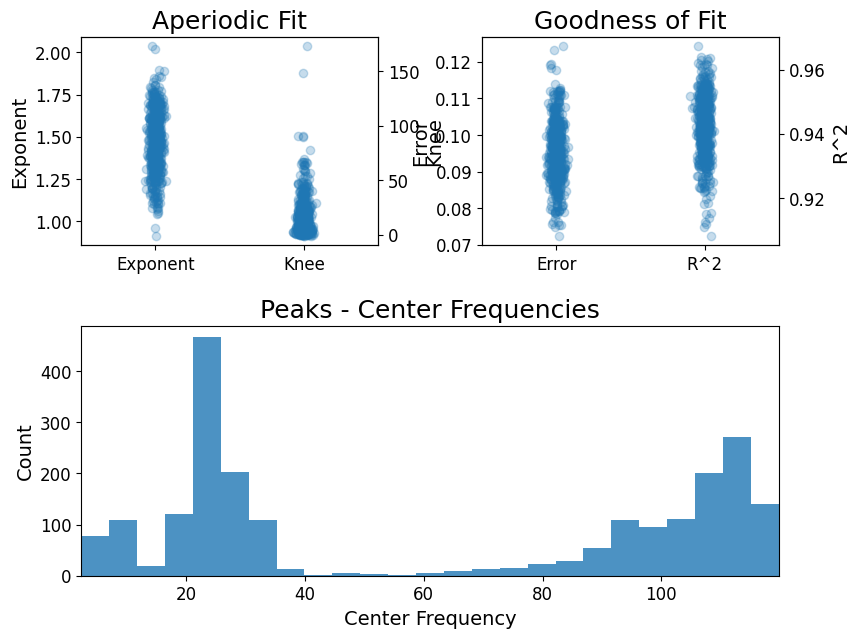

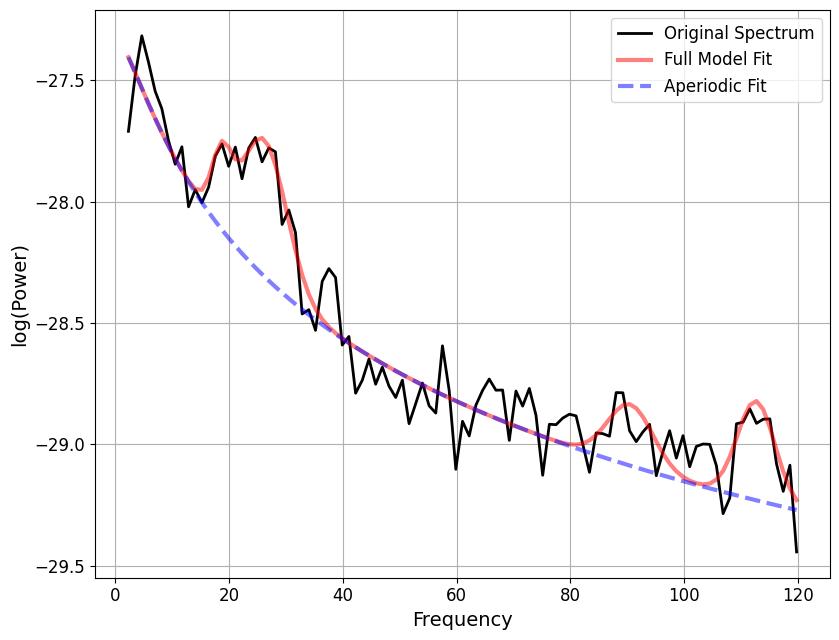

In [66]:
# Print out the group results and plots of fit parameters
fg.print_results()
fg.plot()
fg.get_fooof(1).plot()
bands = Bands({key: value for key, value in zip(saflow.FREQS_NAMES, saflow.FREQS)})
fg.get_fooof(0).to_df(bands)

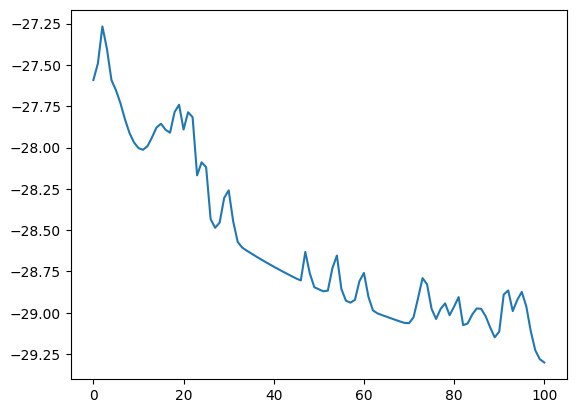

## Save fit information

FileNotFoundError: [Errno 2] No such file or directory: '../Output/EOP_demo.pdf'

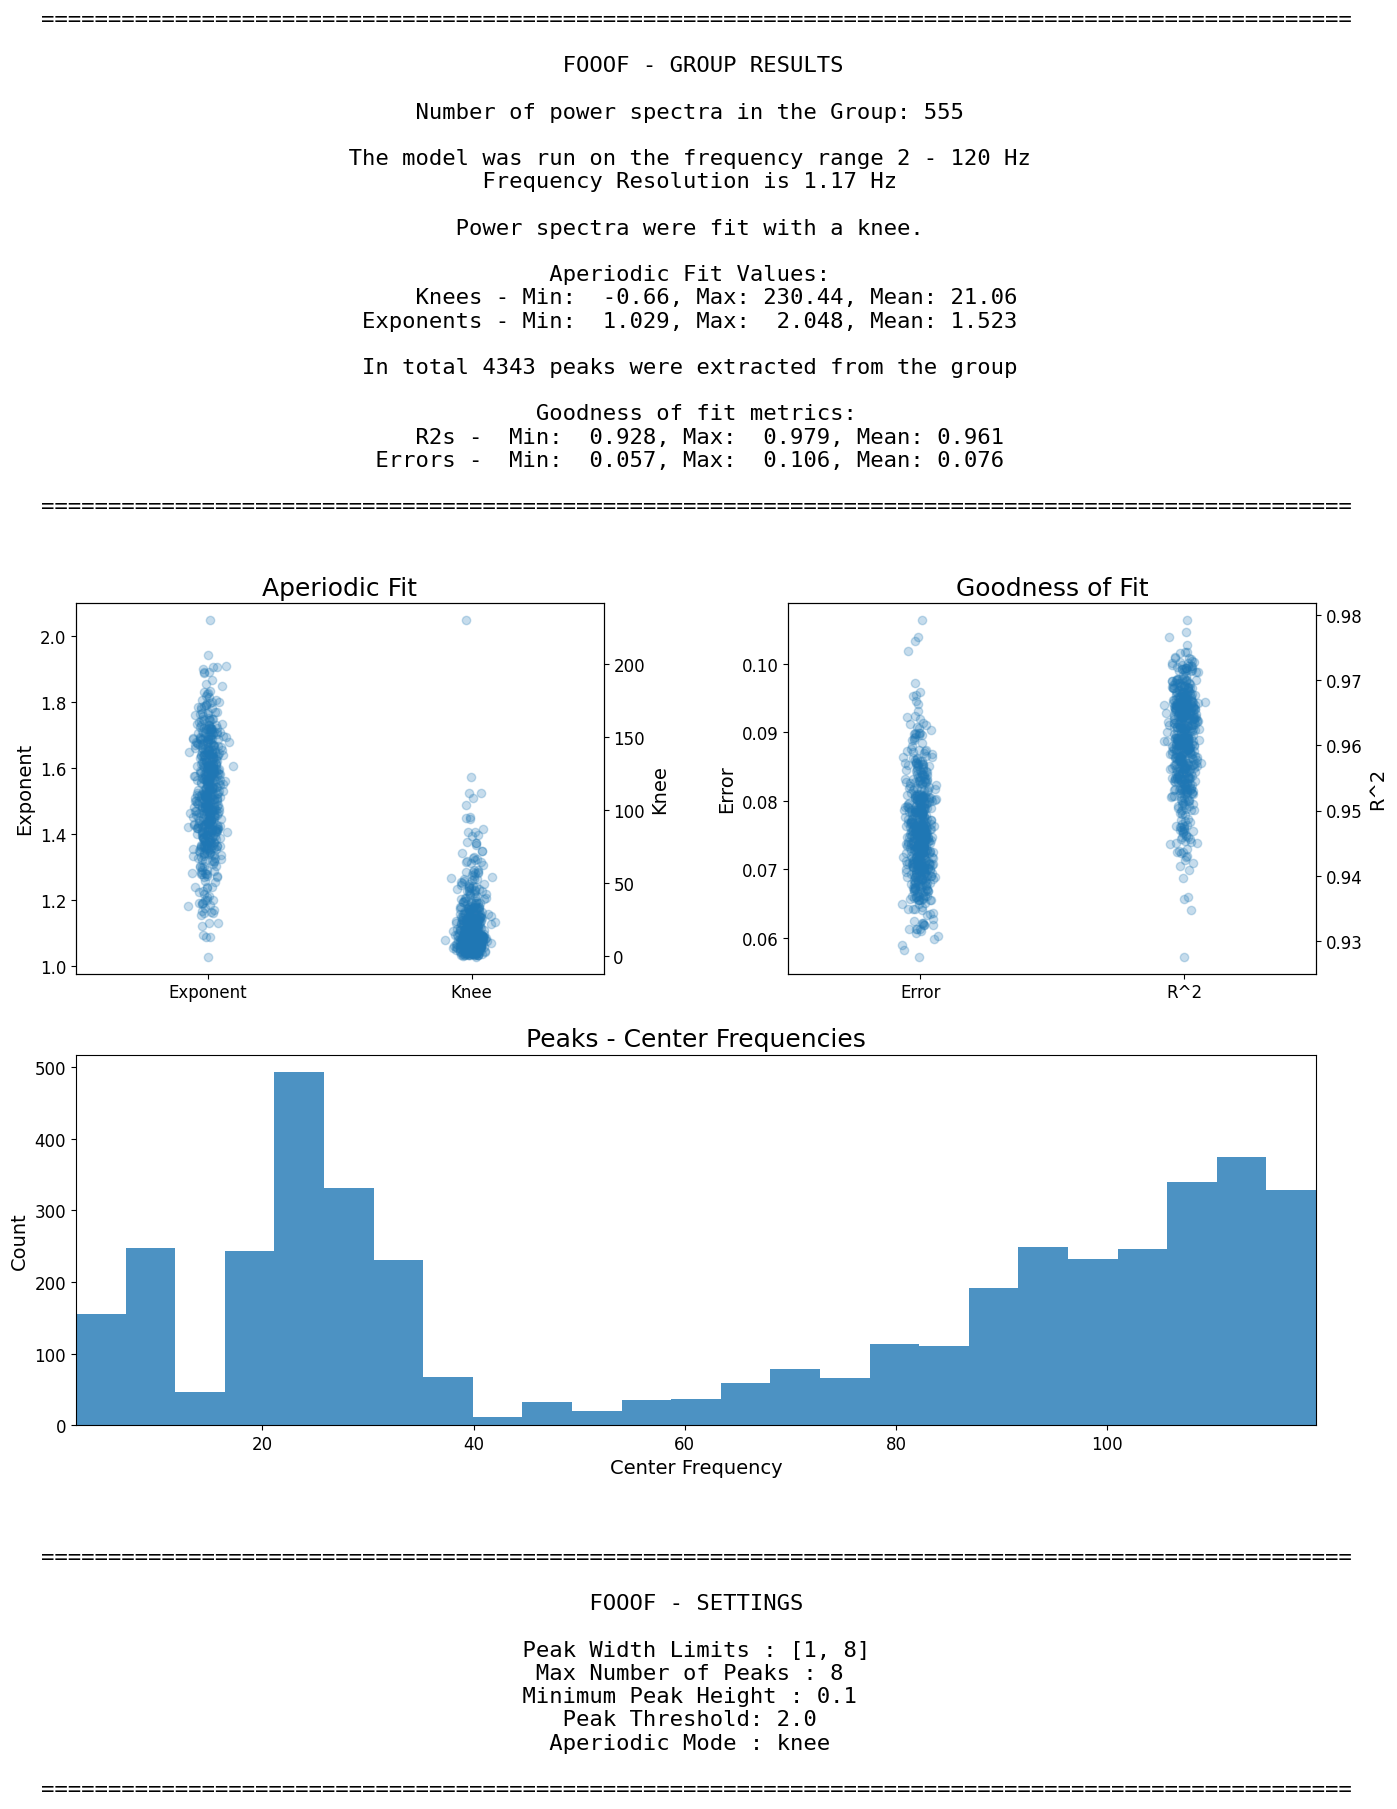

In [16]:
# Save out a copy of the model fit report
fg.save_report('EOP_demo', file_path=output_path)

# The following line can also be used to save out the group plot
#fg.plot(save_fig=True, file_name="EOP_demo", file_path=output_path)

## Extract periodic and aperiodic parameters

As with the individual model object, the `get_params` method can be used to access model fit attributes.

In addition, here we will use a `Bands` object and the `get_band_peak_fg` function to organize fit peaks into canonical band ranges.

In [ ]:
# Extract aperiodic and full periodic parameters
aps = fg.get_params('aperiodic_params')
per = fg.get_params('peak_params')

In [ ]:
# Extract group fit information
err = fg.get_params('error')
r2s = fg.get_params('r_squared')

In [25]:
# Check the average number of fit peaks, per model
print('Average number of fit peaks: ', np.mean(fg.n_peaks_))

Average number of fit peaks:  7.825225225225225


In [26]:
# Define canonical frequency bands 
bands = Bands({'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]})  

In [27]:
# Extract band-limited peaks information
thetas = get_band_peak_fg(fg, bands.theta)
alphas = get_band_peak_fg(fg, bands.alpha)
betas = get_band_peak_fg(fg, bands.beta)

## Plot model parameters

The specparam module also has functions for plotting the fit parameters. 

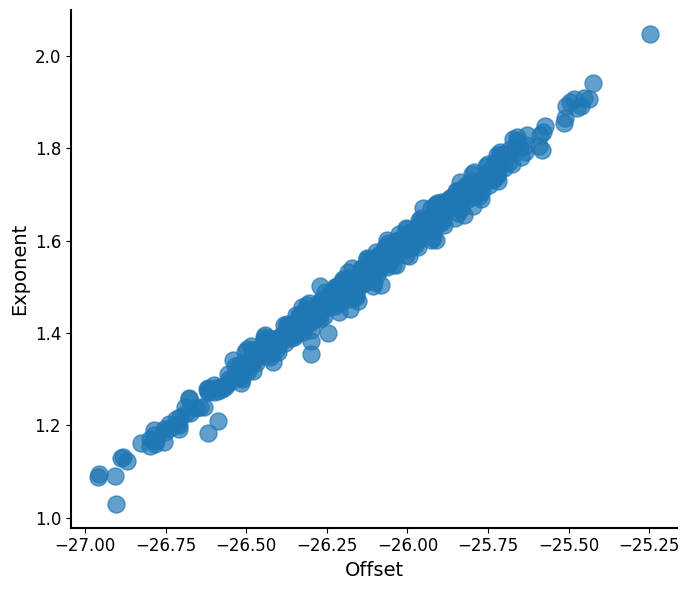

In [28]:
# Plot the measured aperiodic parameters
plot_aperiodic_params(aps)

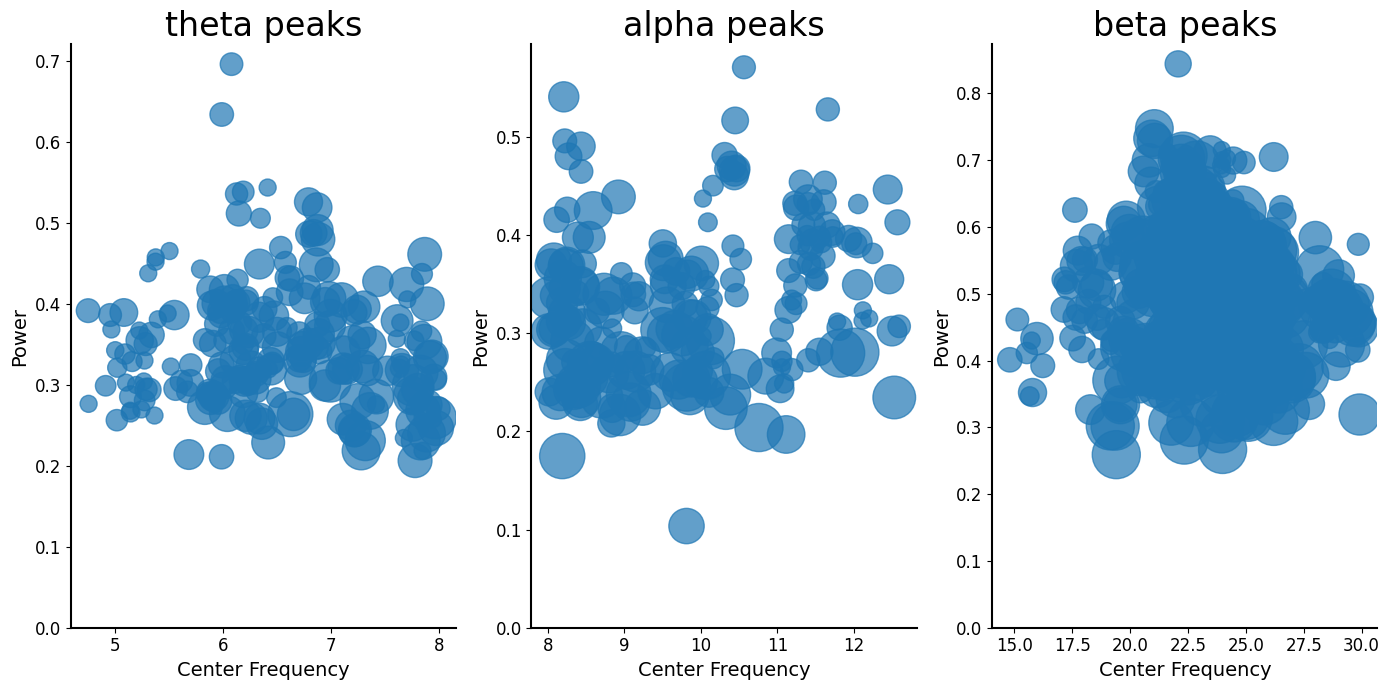

In [29]:
# Plot the parameters for peaks, split up by band
_, axes = plt.subplots(1, 3, figsize=(14,7))
all_bands = [thetas,alphas,betas]
for ax, label, peaks in zip(np.ravel(axes), bands.labels, all_bands):
    plot_peak_params(peaks, ax=ax)
    ax.set_title(label + ' peaks', fontsize=24)
plt.subplots_adjust(hspace=0.4)

## Plot model components

We can also plot reconstructions of model components.

In the following, we plot reconstructed alpha peaks and aperiodic components.

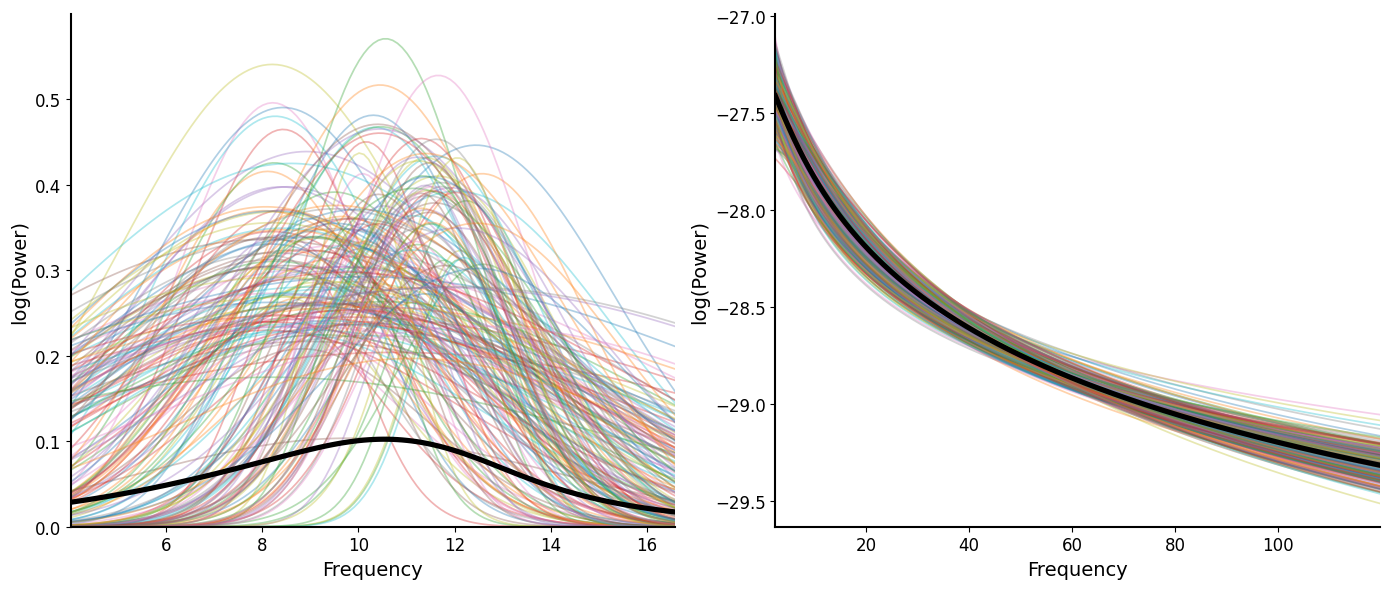

In [30]:
# Plot reconstructions of model components
_, axes = plt.subplots(1, 2, figsize=(14,6))
plot_peak_fits(alphas, ax=axes[0])
plot_aperiodic_fits(aps, fg.freq_range, ax=axes[1])

## Tuning the specparam algorithm 
There are no strict guidelines about optimal parameters that will be appropriate across data sets and recording modalities. We suggest applying a data-driven approach to tune model fitting for optimal performance, while taking into account your expectations about periodic and aperiodic activity given the data, the question of interest, and prior findings. 

One option is to parameterize a subset of data to evaluate the appropriateness of model fit settings prior to fitting each power spectrum in the data set. Here, we test parameters on a randomly selected 10% of the data. Results are saved out to a **Output** folder for further consideration.

#### Subsample spectra to compare between models

First, lets randomly sub-sample 10% of the power spectra that we will use to test model settings.

In [22]:
# Set random seed
np.random.seed(1)

In [23]:
# Define settings for subsampling a selection of power spectra
subsample_frac = 0.10
n_sample = int(n_subjs * subsample_frac)

# Select a random selection of spectra to explore
select = np.random.choice(n_subjs, int(n_subjs * subsample_frac), replace=False)
spectra_subsample = spectra[select, :]

#### Define settings for each model

Here, we define settings for two models to be fit and compared. 

In [24]:
# Define `peak_width_limit` for each model
m1_peak_width = [2, 5]
m2_peak_width = [1, 8]

# Define `max_n_peaks` for each model
m1_n_peaks = 4
m2_n_peaks = 6

# Define `min_peak_height` for each model
m1_peak_height = 0.05
m2_peak_height = 0.10

#### Set frequency ranges for each model

To sub-select frequency ranges, we will use the 
[`trim_spectrum`](https://fooof-tools.github.io/fooof/generated/fooof.utils.trim_spectrum.html#fooof.utils.trim_spectrum)
function to extract frequency ranges of interest for each model.

In [25]:
# Define frequency range for each model
m1_PSD_range = [2, 20]
m2_PSD_range = [3, 40]

# Sub-select frequency ranges
m1_freq, m1_spectra = trim_spectrum(freqs, spectra_subsample, m1_PSD_range)
m2_freq, m2_spectra = trim_spectrum(freqs, spectra_subsample, m2_PSD_range)

#### Fit models, with different settings

In [26]:
# Fit model object with model 1 settings
fg1 = FOOOFGroup(peak_width_limits=m1_peak_width, max_n_peaks=m1_n_peaks, min_peak_height=m1_peak_height)
fg1.fit(m1_freq, m1_spectra)

# Create individual reports for model 1 settings
for ind in range(len(fg1)):
    temp_model = fg1.get_fooof(ind, regenerate=True)
    temp_model.save_report(file_name='EOP_' + str(ind) + '_fm1_settings', file_path=output_path)

Running FOOOFGroup across 6 power spectra.


/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize

In [27]:
# Fit model object with model 2 settings
fg2 = FOOOFGroup(peak_width_limits=m2_peak_width, max_n_peaks=m2_n_peaks, min_peak_height=m2_peak_height)
fg2.fit(m2_freq, m2_spectra)

# Create individual reports for model 2 settings
for ind in range(len(fg2)):
    temp_model = fg2.get_fooof(ind, regenerate=True)
    temp_model.save_report(file_name='EOP_' + str(ind) + '_fm2_settings', file_path=output_path)

/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))


Running FOOOFGroup across 6 power spectra.


/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorr

#### Other ways to manage settings

Another way to manage model settings is with the `FOOOFSettings` object. 

Here we will redefine group model objects (`FOOOFGroup`), again using different settings for each one.

In [28]:
# Define settings for model 1
settings1 = FOOOFSettings(peak_width_limits=m1_peak_width, max_n_peaks=m1_n_peaks, 
                          min_peak_height=m1_peak_height, peak_threshold=2.,
                          aperiodic_mode='fixed')

# Define settings for model 2
settings2 = FOOOFSettings(peak_width_limits=m2_peak_width, max_n_peaks=m2_n_peaks, 
                          min_peak_height=m2_peak_height, peak_threshold=2.,
                          aperiodic_mode='fixed')

In [29]:
# Initialize model objects for spectral parameterization, with some settings
fg1 = FOOOFGroup(*settings1)
fg2 = FOOOFGroup(*settings2)

#### Fit models with group model object

Note that when fitting power spectra, you can can specify a fit range to fit the model to, so you don't have to explicitly trim the spectra.

Here we will refit the example data, specifying the fit range, and then save the group reports. 

In [30]:
# Fit group PSD over the 2-20 Hz and 3-40 Hz ranges, respectively
fg1.fit(freqs, spectra_subsample, freq_range=m1_PSD_range)
fg2.fit(freqs, spectra_subsample, freq_range=m2_PSD_range)

/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize

Running FOOOFGroup across 6 power spectra.
Running FOOOFGroup across 6 power spectra.


In [31]:
# Print and save subset results and plots of fit parameters, for further examination
fg1.save_report(file_name='EOP_' + 'fg1_settings', file_path=output_path)
fg2.save_report(file_name='EOP_' + 'fg2_settings', file_path=output_path)

## Check model fits
After selecting initial model fit settings, and fitting  power spectra from the full sample, it is often worthwhile to check the goodness of model fit parameters. Please note, the model objects below correspond to the model fit at the top of this script.

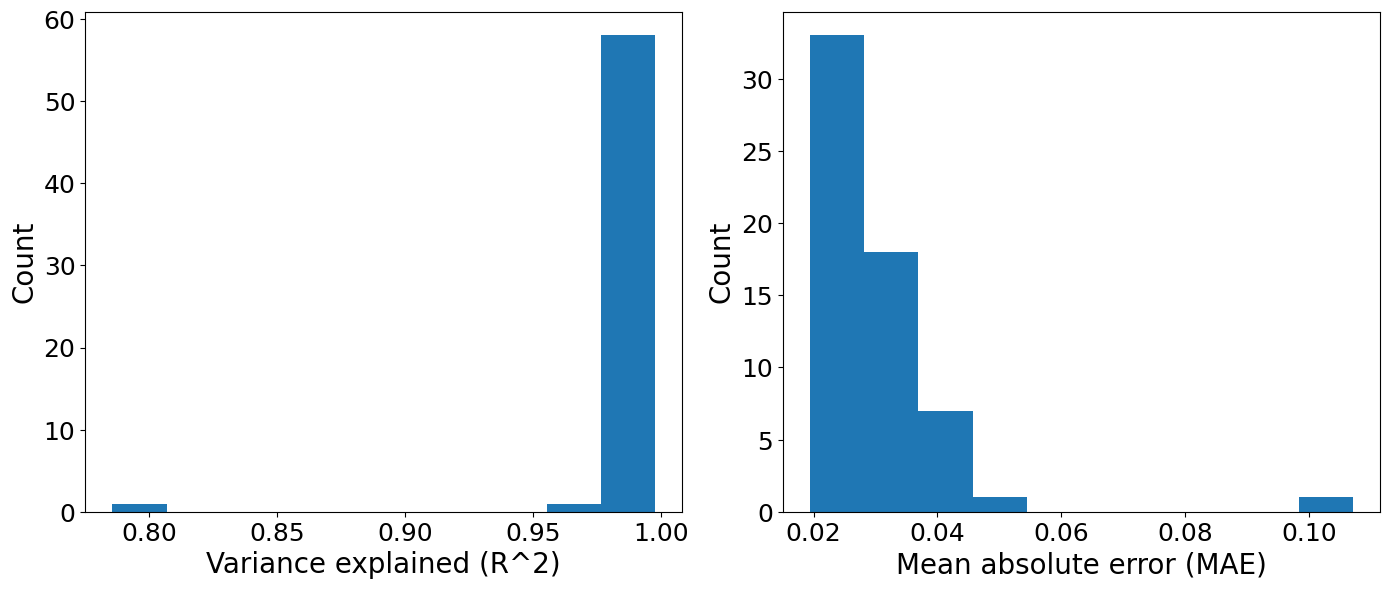

In [32]:
# Plot distributions of goodness of fit parameters
# This information is presented in the print_reports output as well
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(14,6))

ax0.hist(r2s)
ax0.set_xlabel('Variance explained (R^2)', fontsize=20)
ax0.set_ylabel('Count', size=20)
ax0.tick_params(labelsize=18)

ax1.hist(err)
ax1.set_xlabel('Mean absolute error (MAE)', fontsize=20)
ax1.set_ylabel('Count', size=20)
ax1.tick_params(labelsize=18)

fig.tight_layout()
plt.show()

In [33]:
# Find the index of the worst model fit from the group
worst_fit_ind = np.argmax(fg.get_params('error'))

# Extract this model fit from the group
fm = fg.get_fooof(worst_fit_ind, regenerate=True)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.2832, 0.4376                                          
                                                                                                  
                                       1 peaks were found:                                        
          

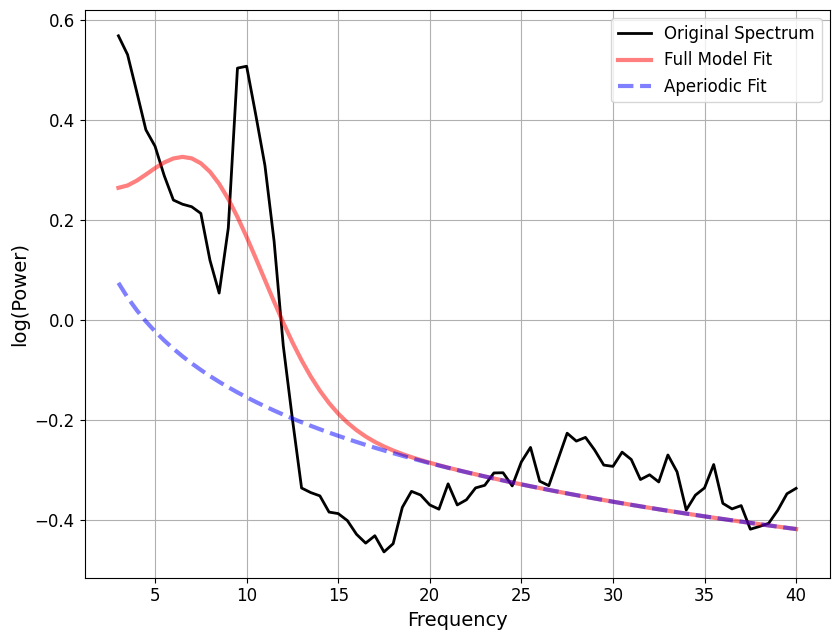

In [34]:
# Check results and visualize the extracted model
fm.print_results()
fm.plot()

### Underfitting

In [35]:
# Extract all fits that are above some error threshold, for further examination.
underfit_error_threshold = 0.100
underfit_check = []
for ind, res in enumerate(fg):
    if res.error > underfit_error_threshold:
        underfit_check.append(fg.get_fooof(ind, regenerate=True))

/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))


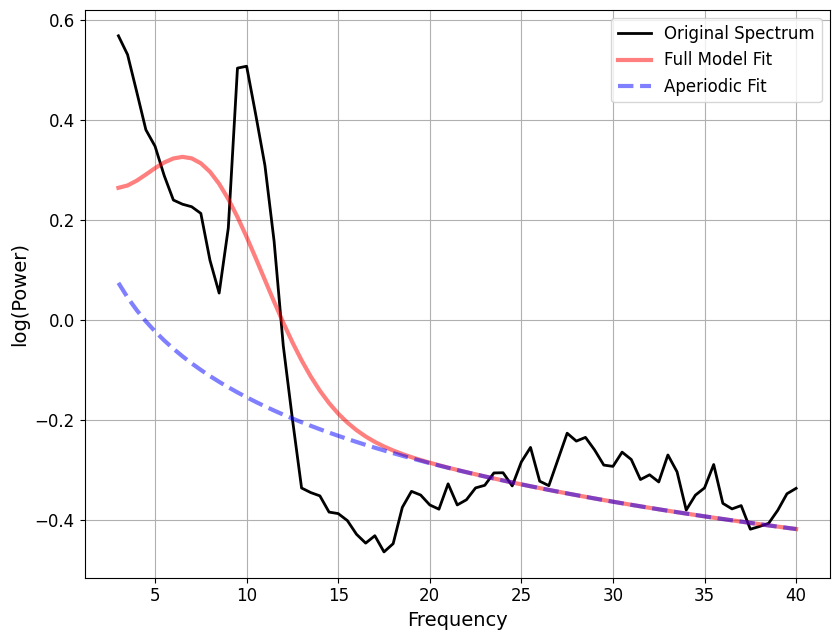

In [36]:
# Loop through the problem fits and save out reports, to check later.
for ind, fm in enumerate(underfit_check):
    fm.plot()
    fm.save_report('EOP_UnderFit_ToCheck_#' + str(ind), file_path=output_path)

### Overfitting

In [37]:
# Extract all fits that are below some error threshold, for further examination.
overfit_error_threshold = 0.02
overfit_check = []
for ind, res in enumerate(fg):
    if res.error < overfit_error_threshold:
        overfit_check.append(fg.get_fooof(ind, regenerate=True))

/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/fooof/core/reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))


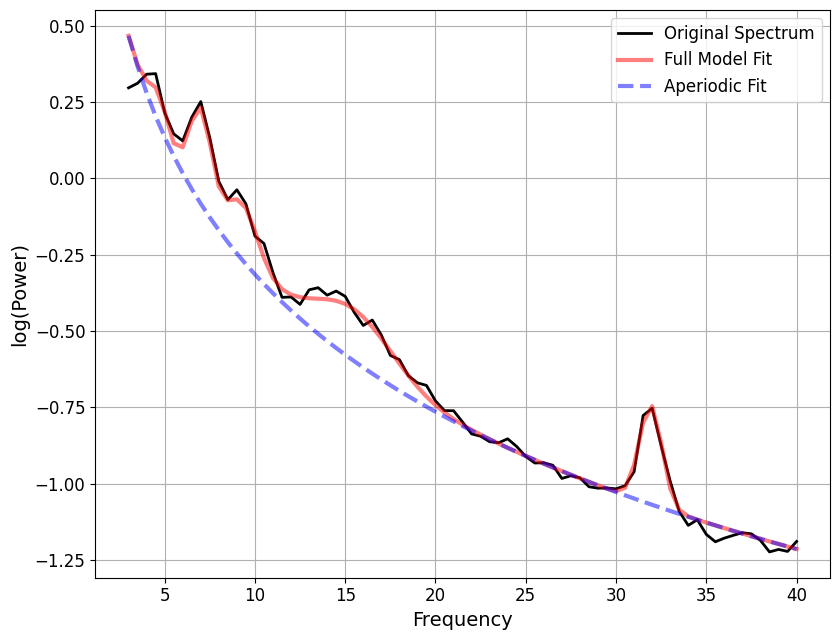

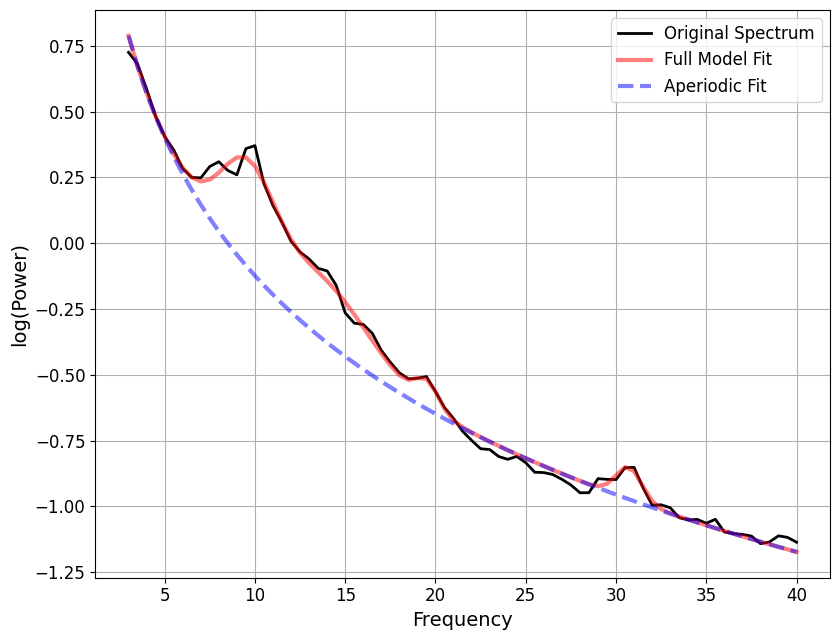

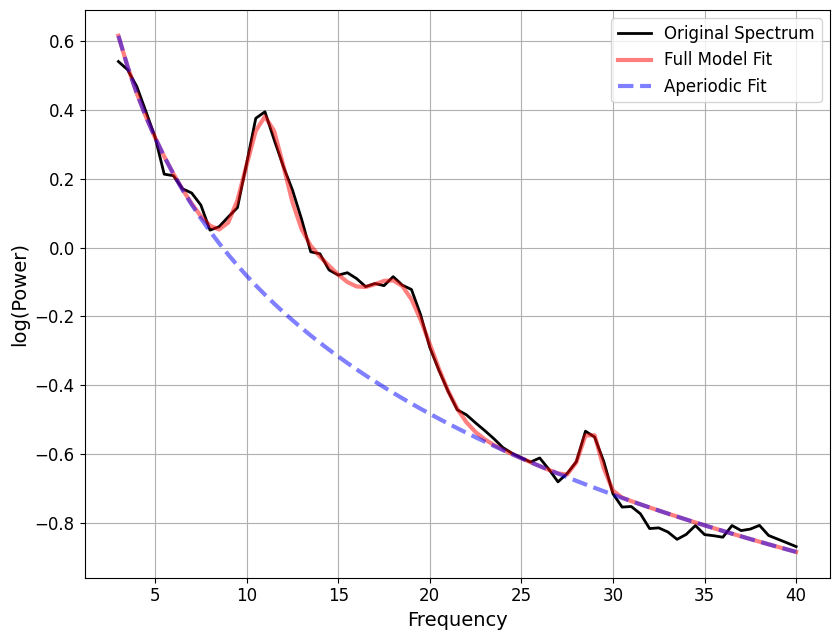

In [38]:
# Loop through the problem fits and save out reports, to check later.
for ind, fm in enumerate(overfit_check):
    fm.plot()
    fm.save_report('EOP_OverFit_ToCheck_#' + str(ind), file_path=output_path)

## Save out data

The same approach for saving out data is available in the group object, using the `save` method. 

In [39]:
# Save out the settings used to fit the models
fg.save('group_settings', save_settings=True, file_path=output_path)

# Save out the results of the model fits
fg.save('group_results', save_results=True, file_path=output_path)

Another option is to save out data as a CSV file. 

In [40]:
# Save out aperiodic parameter results
aper = pd.DataFrame(aps)
aper.columns = ['offset','exponent']
aper.to_csv(output_path / 'EOP_demo_aper.csv')   

In [41]:
# Save out periodic parameter results
per = pd.DataFrame(per)
per.columns = ['CF','PW','BW','index']

per['index'] = per['index'] 
per['seq'] = per.groupby('index').cumcount() + 1
per = per.pivot(index='index', columns='seq', values=['CF','PW','BW'])

per.to_csv(output_path / 'EOP_demo_per.csv')

In [42]:
# Save out model fit results
fit = pd.DataFrame([r2s, err]).transpose()
fit.columns = ['r2s','error']
fit.to_csv(output_path / 'EOP_demo_fits.csv')

### Reload Data

We can also check our saved out results by reloading them. 

In [43]:
# Reload the saved out group model results
nfg = FOOOFGroup()
nfg.load('group_results', file_path=output_path)

In [44]:
# Check the results of the reloaded model fit
nfg.print_results()

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 60                             
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

## Frequency-by-frequency error
It can be useful to plot frequency-by-frequency error of the model fit, to identify where in frequency space the spectrum is (or is not) being fit well. When fitting individual spectrum, this can be accomplished using the `compute_pointwise_error_fg` function. When plotting the error, the plot line is the mean error per frequency, across fits, and the shading indicates the standard deviation of the error, also per frequency.

In this case, we can see that error fluctuates around 0.03, which is the same as the mean absolute error for this group fit. There are points in the spectrum where the model fit is somewhat poor, particularly < 4 Hz. The code below lets you identify the highest mean error and largest standard deviation in error for the group fit. In this case, that occurs at 3 Hz, suggesting potential issues with fit at the lower end of the examined frequency range.

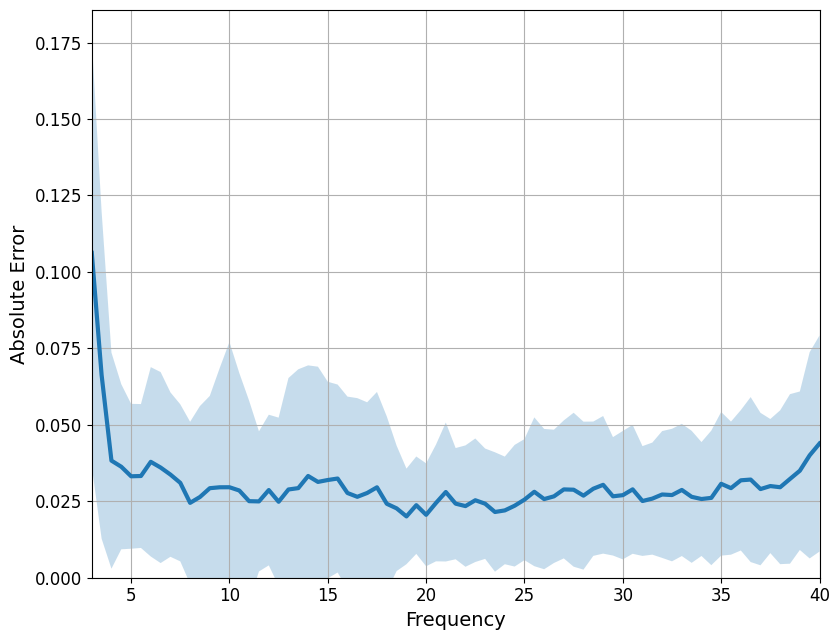

In [45]:
# Plot frequency-by-frequency error 
compute_pointwise_error_fg(fg, plot_errors=True)

In [46]:
# Return the errors - this returns a 2D matrix of errors for all fits
errs_fg = compute_pointwise_error_fg(fg, plot_errors=False, return_errors=True)

In [47]:
# Check which frequency has the highest error
f_max_err = fg.freqs[np.argmax(np.mean(errs_fg, 0))]
print('Frequency with highest mean error: \t\t\t', f_max_err)

Frequency with highest mean error: 			 3.0


In [48]:
# Check which frequency has the largest standard deviation of error
f_max_std = fg.freqs[np.argmax(np.std(errs_fg, 0))]
print('Frequency with highest standard deviation of error: \t', f_max_std)

Frequency with highest standard deviation of error: 	 3.0


In some cases, it may be necessary to drop poor (or failed) model fits from the group object. This can be done using the `fg.drop` function, as shown here. In this case, we remove a participant who has a MAE greater than 0.10. The error threshold will vary depending on sample characteristics and data quality.

In [49]:
# Drop poor model fits based on MAE
fg.drop(fg.get_params('error') > 0.10)